In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 200)
pd.set_option('max_colwidth', 200)

In [2]:
train = pd.read_csv('data/train_base.csv')
test = pd.read_csv('data/test_base.csv')

category: feature_1、feature_2、feature_3、

In [11]:
train_y = train[['target']]
train_id = train[['card_id']]
test_id = test[['card_id']]

In [12]:
train_x = train.drop(['target', 'card_id'], axis=1)
test_x = test.drop(['card_id'], axis=1)

In [13]:
from sklearn.model_selection import KFold

n_fold = 5
x_score = []
cv_pred = []
test_pred = []
skf = KFold(n_splits=n_fold, random_state=0, shuffle=True)

In [14]:
# relation = train_x.corr()

# length = relation.shape[0]
# high_corr = list()
# final_cols = []
# del_cols =[]
# for i in range(length):
#     if relation.columns[i] not in del_cols:
#         final_cols.append(relation.columns[i])
#         for j in range(i+1,length):
#             if (relation.iloc[i,j] > 0.96) and (relation.columns[j] not in del_cols):
#                 del_cols.append(relation.columns[j])

# train_x = train_x[final_cols]
# test_x = test_x[final_cols]
# print('final columns shape : ', len(final_cols))
# print('del columns shape : ',len(del_cols))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-0cd9326d1b57>", line 1, in <module>
    relation = train_x.corr()
  File "D:\anaconda\lib\site-packages\pandas\core\frame.py", line 6497, in corr
    correl = libalgos.nancorr(_ensure_float64(mat), minp=min_periods)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\IPython\core\ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb

KeyboardInterrupt: 

3.65784

In [7]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
          'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [8]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_x))
predictions = np.zeros(len(test_x))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_x.values, train_y.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_x.iloc[trn_idx],
                           label=train_y.iloc[trn_idx],
                          )
    val_data = lgb.Dataset(train_x.iloc[val_idx],
                           label=train_y.iloc[val_idx],
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["feature"] = train_x.columns
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_x, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, train_y)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72259	valid_1's rmse: 3.78301
[200]	training's rmse: 3.65425	valid_1's rmse: 3.73489
[300]	training's rmse: 3.60925	valid_1's rmse: 3.70979
[400]	training's rmse: 3.57557	valid_1's rmse: 3.69647
[500]	training's rmse: 3.54925	valid_1's rmse: 3.68864
[600]	training's rmse: 3.52779	valid_1's rmse: 3.68359
[700]	training's rmse: 3.50941	valid_1's rmse: 3.67992
[800]	training's rmse: 3.4943	valid_1's rmse: 3.67779
[900]	training's rmse: 3.48052	valid_1's rmse: 3.67653
[1000]	training's rmse: 3.46759	valid_1's rmse: 3.67532
[1100]	training's rmse: 3.45494	valid_1's rmse: 3.67468
[1200]	training's rmse: 3.44327	valid_1's rmse: 3.67387
[1300]	training's rmse: 3.43199	valid_1's rmse: 3.67371
[1400]	training's rmse: 3.42078	valid_1's rmse: 3.67336
[1500]	training's rmse: 3.41086	valid_1's rmse: 3.67325
[1600]	training's rmse: 3.40093	valid_1's rmse: 3.67331
Early stopping, best iteration is:
[1481]	

Text(0.5,1,'LightGBM Features (avg over folds)')

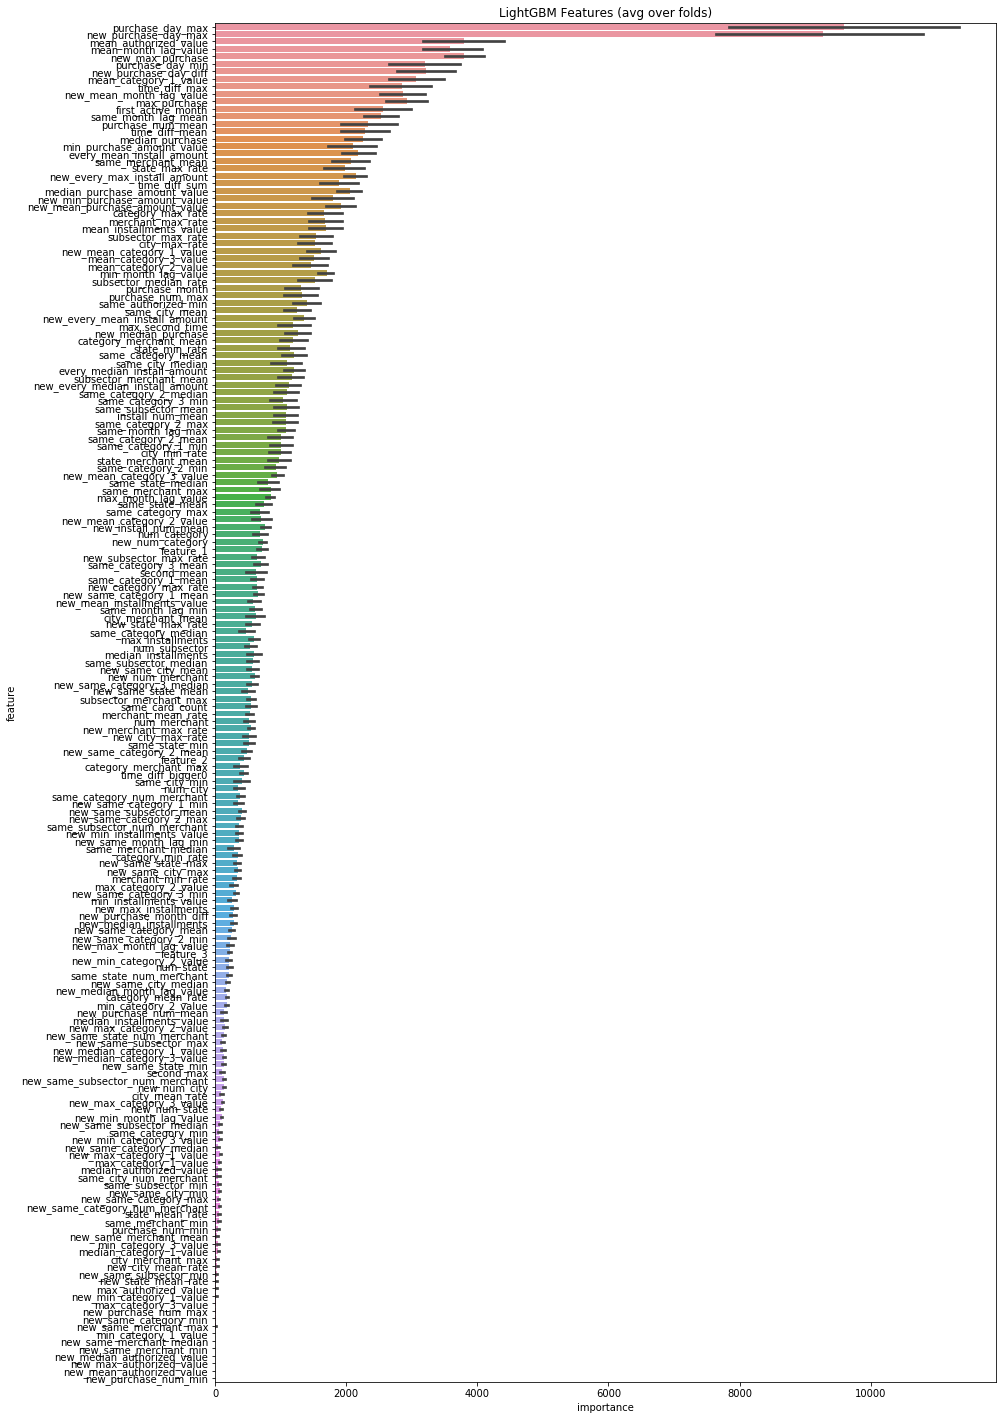

In [17]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')

In [9]:
prediction = test_id
prediction['target'] = predictions

In [10]:
prediction.to_csv('submit/lgb_base.csv', index=None)

In [9]:
import xgboost as xgb

def XGB():
    clf = xgb.XGBRegressor(max_depth=12, learning_rate=0.1,
                            n_estimators=2000, objective="reg:linear",
                            gamma=0, eval_metric='rmse', subsample=0.8,nthread=4, colsample_bytree=0.8,
                            reg_alpha=0.1, reg_lambda=0.8, seed=1994, missing=None)
    return clf

In [10]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_x))
predictions = np.zeros(len(test_x))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_x.values, train_y.values)):
    print("fold n°{}".format(fold_))
    x_train, x_valid, y_train, y_valid = train_x.loc[trn_idx], train_x.loc[val_idx], train_y.loc[trn_idx], train_y.loc[val_idx]
    clf = XGB()
    clf.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=1, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(x_valid)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["feature"] = train_x.columns
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_x) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, train_y)**0.5))

fold n°0
[0]	validation_0-rmse:3.9443
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:3.90702
[2]	validation_0-rmse:3.87769
[3]	validation_0-rmse:3.85748
[4]	validation_0-rmse:3.83782
[5]	validation_0-rmse:3.81997
[6]	validation_0-rmse:3.8075
[7]	validation_0-rmse:3.79674
[8]	validation_0-rmse:3.78569
[9]	validation_0-rmse:3.77544
[10]	validation_0-rmse:3.77172


KeyboardInterrupt: 